<a href="https://colab.research.google.com/github/SergeiVKalinin/MLSTEM2024/blob/main/Day4/Day4_ExplainableML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial notebook for the Summer 2024 short course "Machine Learning for Scanning Transmission Electron Microscopy", organized by Gerd Duscher and Sergei V. Kalinin, University of Tennessee, Knoxville

Course GitHub: https://github.com/gduscher/MLSTEM2024
- Gerd Duscher: https://scholar.google.com/citations?hl=en&user=kAI2T5EAAAAJ
- Sergei V. Kalinin: https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ&view_op=list_works&sortby=pubdate


# Explainable NN: LIME

In [1]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=3c6fe848196fa196f7762392849c1a777a1ee3e1e82e01390f6061436d37fd6a
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


## LIME for Iris

In [2]:
import lime
import lime.lime_tabular
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load Iris dataset
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=42)

# Train a Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Initialize a LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=iris.feature_names, class_names=iris.target_names, discretize_continuous=True)

# Choose an instance to explain
idx = 20  # Change this to explain different test instances
instance = X_test[idx]

# Generate explanation for the chosen instance
exp = explainer.explain_instance(instance, rf.predict_proba, num_features=4, top_labels=1)

# Show the explanation
exp.show_in_notebook(show_table=True, show_all=False)
# Or use exp.as_pyplot_figure() if not using Jupyter Notebook

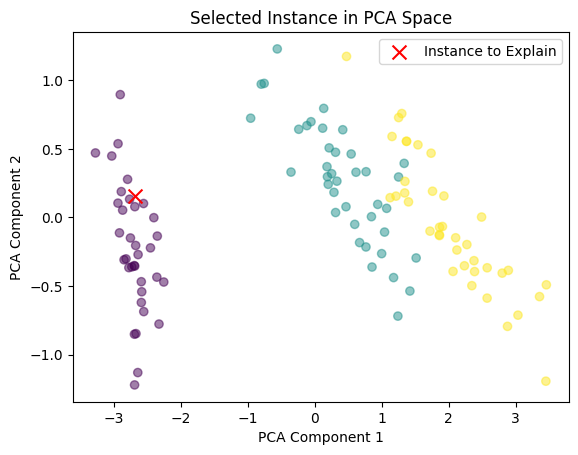

In [3]:
from sklearn.decomposition import PCA

# PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Plotting the selected instance
instance_pca = pca.transform(instance.reshape(1, -1))

# Highlight the selected instance
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.scatter(instance_pca[:, 0], instance_pca[:, 1], color='red', marker='x', s=100, label='Instance to Explain')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.title('Selected Instance in PCA Space')
plt.show()


##LIME for Cat (or CIFAR)

In [4]:
!gdown https://drive.google.com/uc?id=1e9qvvitE0e5FRz1kGpR-4k8vRv6i9Zbp

import tensorflow as tf
cat_image = tf.io.read_file('/content/cute.jpg')
cat_image = tf.image.decode_jpeg(cat_image)
cat_image = tf.image.resize(cat_image, (299, 299))  # Resize to match InceptionV3 input size

Downloading...
From: https://drive.google.com/uc?id=1e9qvvitE0e5FRz1kGpR-4k8vRv6i9Zbp
To: /content/cute.jpg
100% 140k/140k [00:00<00:00, 131MB/s]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg16
from tensorflow.keras.datasets import cifar10

from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.transform import resize

# Load VGG16 model pre-trained on ImageNet
model = vgg16.VGG16(weights='imagenet', include_top=True)

# Load CIFAR-10 data
(_, _), (x_test, y_test) = cifar10.load_data()

# Select an image from CIFAR-10
image = x_test[9]
image = np.array(cat_image) #comment this line out to explore for CIFAR-10

# Resize the image to 224x224 for VGG16
image_resized = resize(image, (224, 224), preserve_range=True)

# Preprocess the image for VGG16 model
image_preprocessed = vgg16.preprocess_input(image_resized.copy())

# Predict the image using VGG16
preds = model.predict(np.array([image_preprocessed]))
predicted_class = vgg16.decode_predictions(preds, top=1)[0][0][1]
print(f"Predicted: {predicted_class}")

# Initialize LIME for image explanation
explainer = lime_image.LimeImageExplainer()

35363/35363 [==============================] - 0s 1us/step
Predicted: kit_fox


In [6]:
# Explain the prediction
explanation = explainer.explain_instance(image_resized.astype(np.float32),
                                         model.predict,
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)

# Display the explanation for the top class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                            positive_only=False,
                                            num_features=10,
                                            hide_rest=True)

# plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
# plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


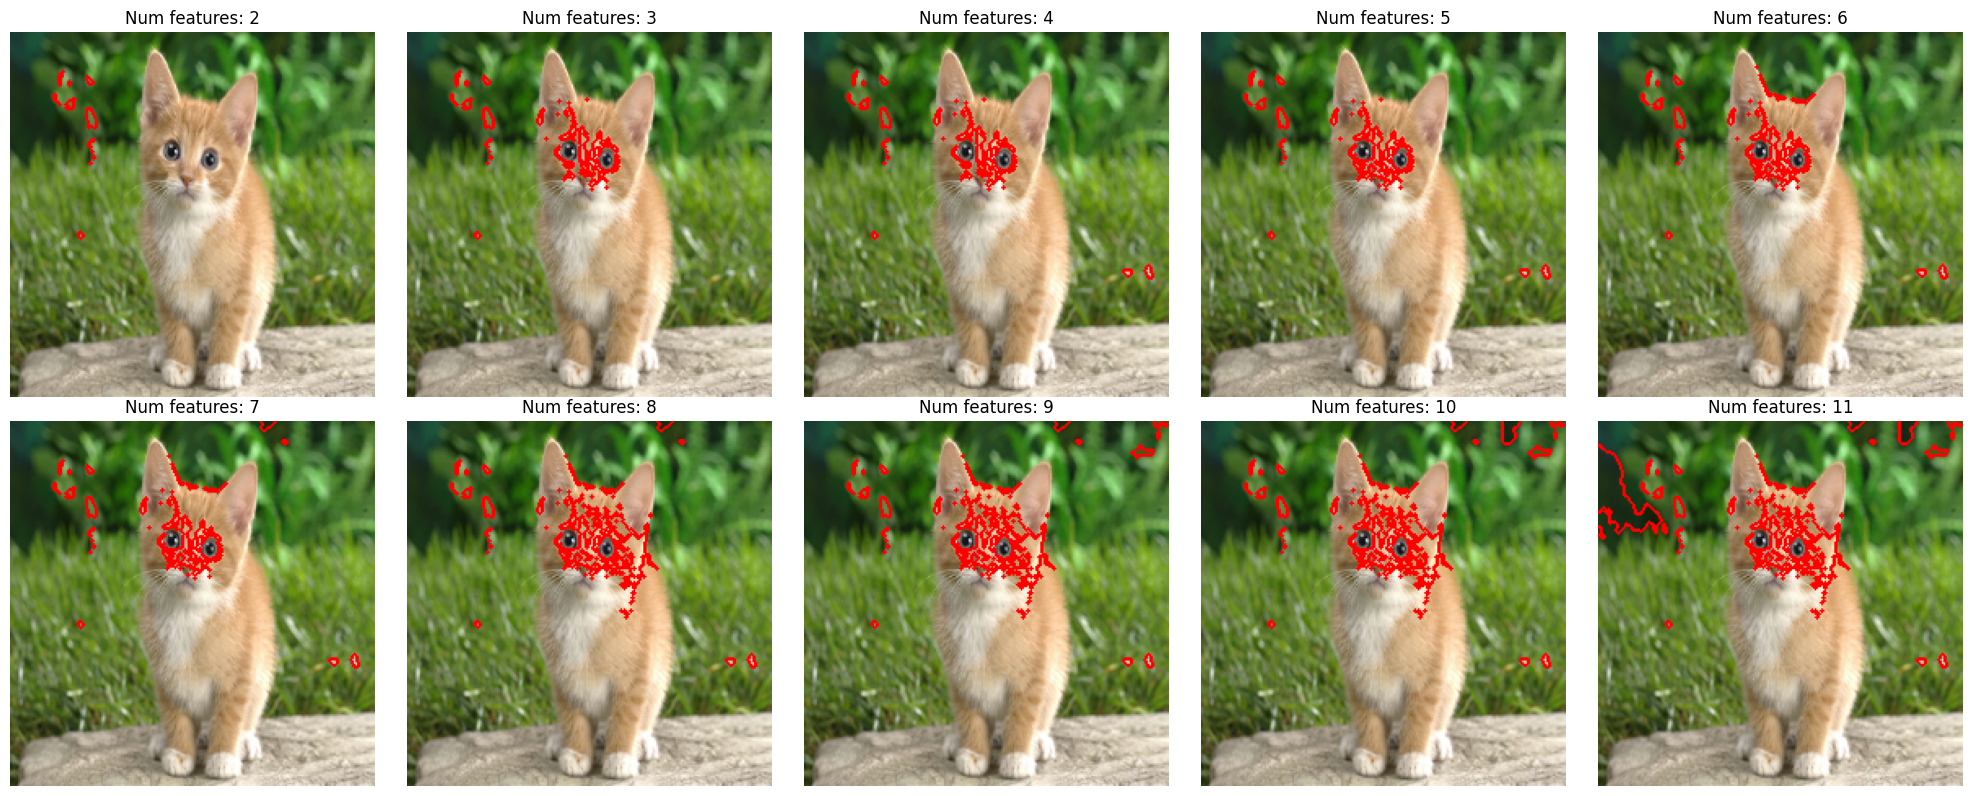

In [7]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Assuming 'explanation' is already obtained from LIME as before

# Create a figure with 5 columns and 2 rows
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, num_features in enumerate(range(2, 12)):
    # Get the mask for the superpixels
    _, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=num_features, hide_rest=False)

    # Find the row and column to place this subplot
    row = i // 5
    col = i % 5

    # Superimpose the mask on the original image
    img_boundaries = mark_boundaries(image_resized / 255.0, mask, color=(1,0,0), mode='thick')

    # Plotting
    axs[row, col].imshow(img_boundaries)
    axs[row, col].set_title(f'Num features: {num_features}')
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()


# Explanable NN: SHAP

In [8]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 12.0 MB/s eta 0:00:00


## SHAP for Iris

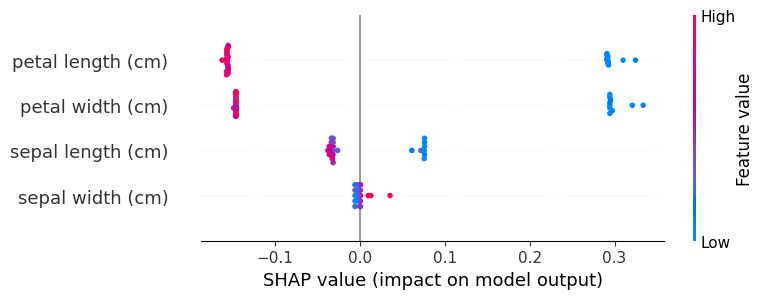

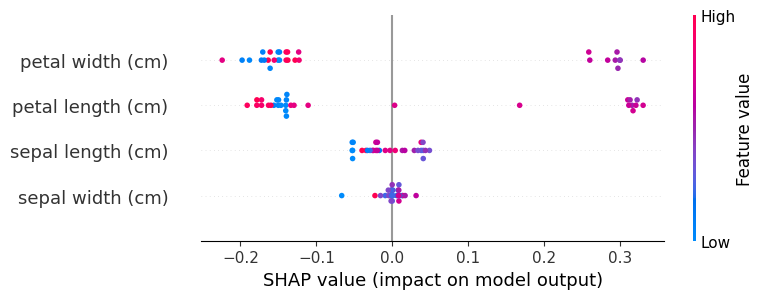

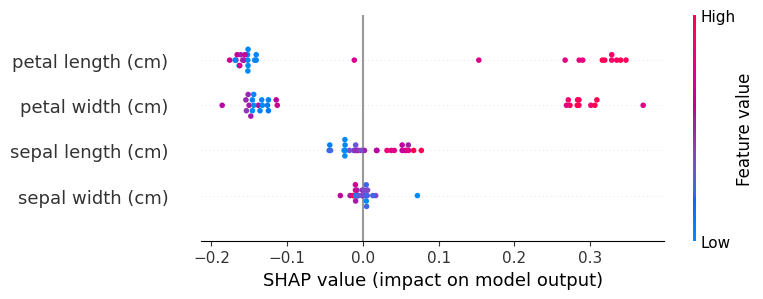

In [9]:
import shap
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# Plot SHAP values with class names
for i in range(len(iris.target_names)):
    shap.summary_plot(shap_values[:,:,i], X_test, feature_names=iris.feature_names, title=iris.target_names[i])


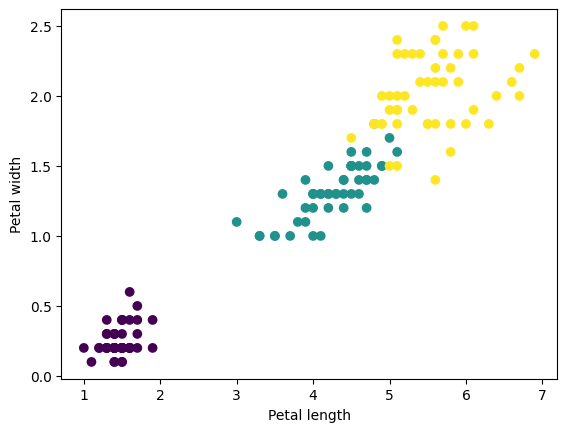

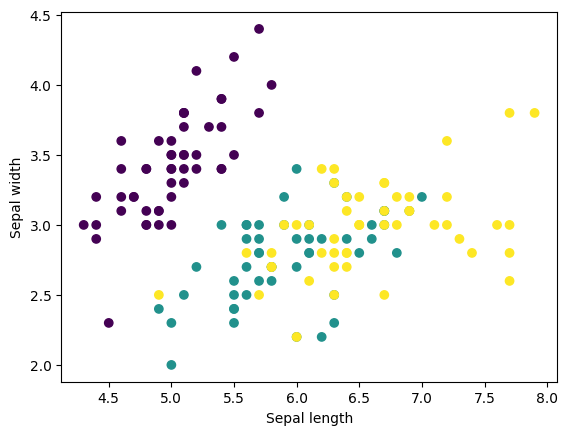

In [10]:
plt.scatter(iris.data[:, 2], iris.data[:, 3], c=iris.target, cmap='viridis')
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.show()

plt.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target, cmap='viridis')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

## SHAP for MNIST

In [11]:
import matplotlib.pyplot as plt
import shap
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
import numpy as np

# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Build the model
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=5, verbose=1)

11490434/11490434 [==============================] - 2s 0us/step
Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2650 - accuracy: 0.9256
Epoch 2/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1181 - accuracy: 0.9659
Epoch 3/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0812 - accuracy: 0.9761
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0610 - accuracy: 0.9807
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0471 - accuracy: 0.9856


/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


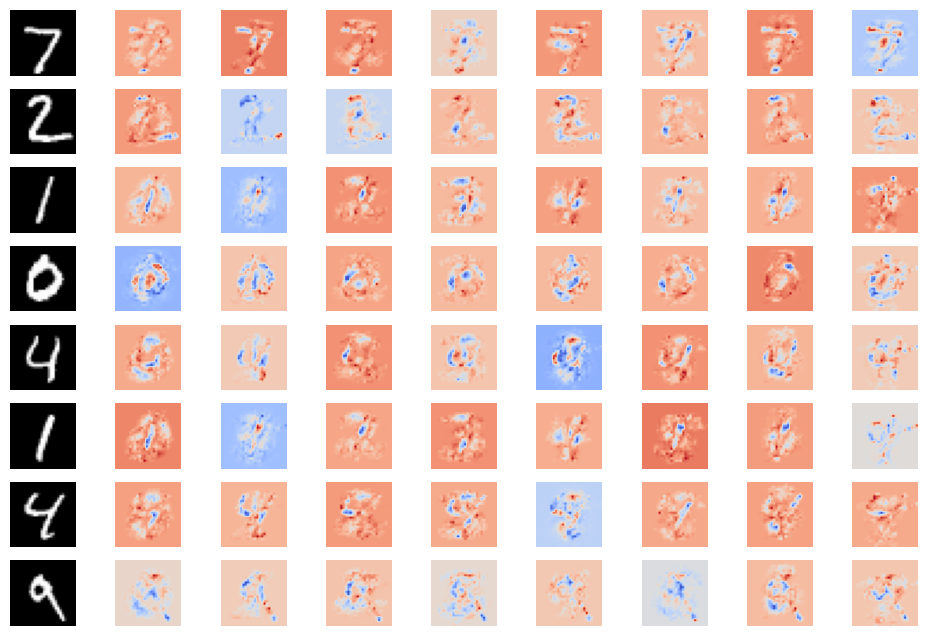

In [12]:
# Select a set of background examples to take an expectation over
background = train_images[np.random.choice(train_images.shape[0], 100, replace=False)]

# Explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images[:8])

# Customizing the plot layout
num_test_images = len(test_images[:8])
fig, axes = plt.subplots(nrows=num_test_images, ncols=len(shap_values) + 1, figsize=(12, 1 * num_test_images))

for i in range(num_test_images):
    axes[i, 0].imshow(test_images[i], cmap='gray')
    axes[i, 0].axis('off')
    for j in range(len(shap_values)):
        mappable = axes[i, j + 1].imshow(shap_values[i,:,:,j], cmap='coolwarm') #shap_values[j][i]
        axes[i, j + 1].axis('off')

# Create space for the colorbar
#plt.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(mappable, cax=cbar_ax)

plt.show()

In [13]:
shap_values.shape

(8, 28, 28, 10)

# Saliency maps on MNIST

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data: normalize and reshape
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, batch_size=128, epochs=15, validation_split=0.1)


Epoch 1/15
422/422 [==============================] - 3s 4ms/step - loss: 0.2455 - accuracy: 0.9295 - val_loss: 0.0849 - val_accuracy: 0.9782
Epoch 2/15
422/422 [==============================] - 1s 3ms/step - loss: 0.0752 - accuracy: 0.9777 - val_loss: 0.0648 - val_accuracy: 0.9827
Epoch 3/15
422/422 [==============================] - 1s 3ms/step - loss: 0.0490 - accuracy: 0.9854 - val_loss: 0.0629 - val_accuracy: 0.9822
Epoch 4/15
422/422 [==============================] - 1s 4ms/step - loss: 0.0363 - accuracy: 0.9891 - val_loss: 0.0508 - val_accuracy: 0.9880
Epoch 5/15
422/422 [==============================] - 1s 3ms/step - loss: 0.0276 - accuracy: 0.9918 - val_loss: 0.0489 - val_accuracy: 0.9880
Epoch 6/15
422/422 [==============================] - 1s 3ms/step - loss: 0.0206 - accuracy: 0.9939 - val_loss: 0.0487 - val_accuracy: 0.9858
Epoch 7/15
422/422 [==============================] - 1s 3ms/step - loss: 0.0158 - accuracy: 0.9956 - val_loss: 0.0471 - val_accuracy: 0.9877
Epoch 

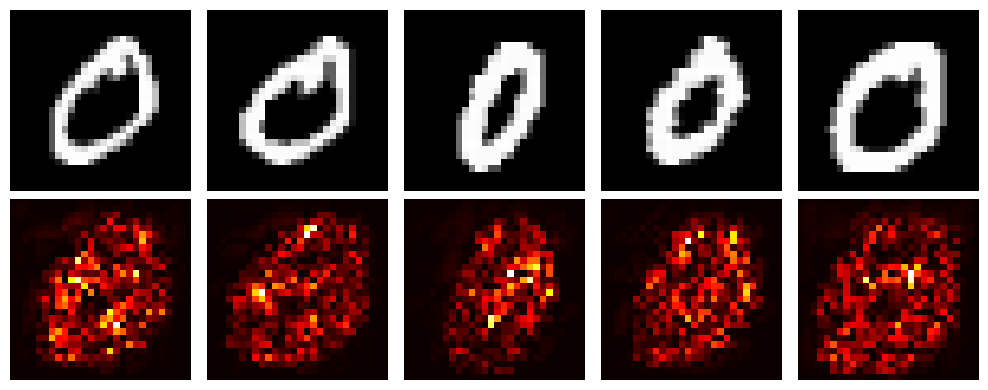

In [16]:
# Function to compute the saliency map
def compute_saliency(model, image):
    with tf.GradientTape() as tape:
        inputs = tf.cast(image, tf.float32)
        tape.watch(inputs)
        predictions = model(inputs[tf.newaxis, ...])
        loss = tf.reduce_max(predictions)

    grads = tape.gradient(loss, inputs)
    saliency = tf.abs(grads).numpy().squeeze()
    return saliency

# Select 5 examples of the digit '8'
indices = np.where(np.argmax(y_train, axis=1) == 0)[0][:5]
images = x_train[indices]

# Plot images and their saliency maps
plt.figure(figsize=(10, 4))
for i, image in enumerate(images):
    saliency_map = compute_saliency(model, image)

    # Original image
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')

    # Saliency map
    plt.subplot(2, 5, i + 6)
    plt.imshow(saliency_map, cmap='hot')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Deep Dream

## MNIST on simple DCNN

In [17]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1)).astype('float32') / 255

# Build a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile and train the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64, verbose=1)

Epoch 1/5
938/938 [==============================] - 5s 4ms/step - loss: 0.1765 - accuracy: 0.9466
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0505 - accuracy: 0.9841
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0374 - accuracy: 0.9882
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0284 - accuracy: 0.9908
Epoch 5/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0230 - accuracy: 0.9929


In [18]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 conv2d_1
1 max_pooling2d_1
2 conv2d_2
3 max_pooling2d_2
4 conv2d_3
5 flatten_2
6 dense_4
7 dense_5


In [19]:
vals = [0, 0, 8, 0, 0, 0, 0]
layer_dict = {}

conv_counter = 0  # Counter for layers starting with 'conv'
for layer in model.layers:
    if layer.name.startswith('conv'):
        if conv_counter < len(vals):
            print(layer.name, vals[conv_counter])
            layer_dict[layer.name] = vals[conv_counter]
            conv_counter += 1

print(layer_dict)


conv2d_1 0
conv2d_2 0
conv2d_3 8
{'conv2d_1': 0, 'conv2d_2': 0, 'conv2d_3': 8}


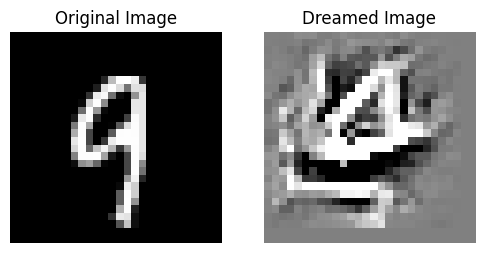

In [20]:
# DeepDream configuration

layer_contributions = layer_dict

# Create a feature extraction model
layer_dict = dict([(layer.name, layer) for layer in model.layers])
dream_model = tf.keras.Model(inputs=model.input, outputs=[layer_dict[name].output for name in layer_contributions])

# DeepDream Function
def deepdream(image, steps, step_size):
    image = tf.convert_to_tensor(image)
    for step in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(image)
            outputs = dream_model(image)
            loss = tf.constant(0.0)
            for out, coeff in zip(outputs, layer_contributions.values()):
                loss += coeff * tf.reduce_mean(tf.square(out))
        gradients = tape.gradient(loss, image)
        gradients /= tf.maximum(tf.reduce_mean(tf.abs(gradients)), 1e-7)
        image += gradients * step_size
        image = tf.clip_by_value(image, -1, 1)
    return image.numpy()

# Select an MNIST test image and apply DeepDream
selected_img = test_images[np.random.randint(len(test_images))]
dreamed_img = deepdream(selected_img[np.newaxis, ...], steps=50, step_size=0.02)

# Plot the original and dreamed images
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(selected_img.squeeze(), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dreamed_img.squeeze(), cmap='gray')
plt.title('Dreamed Image')
plt.axis('off')

plt.show()

## Cat on ImageNet

In [21]:
!gdown https://drive.google.com/uc?id=1e9qvvitE0e5FRz1kGpR-4k8vRv6i9Zbp

Downloading...
From: https://drive.google.com/uc?id=1e9qvvitE0e5FRz1kGpR-4k8vRv6i9Zbp
To: /content/cute.jpg
100% 140k/140k [00:00<00:00, 144MB/s]


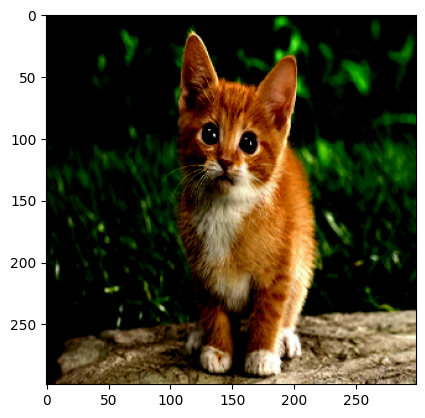

In [22]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

cat_image = tf.io.read_file('/content/cute.jpg')
cat_image = tf.image.decode_jpeg(cat_image)
cat_image = tf.image.resize(cat_image, (299, 299))  # Resize to match InceptionV3 input size
cat_image = tf.cast(cat_image, tf.float32)
cat_image = preprocess_input(cat_image)
cat_image = tf.expand_dims(cat_image, axis=0)  # Add batch dimension

plt.imshow(cat_image[0,:,:,:])

87910968/87910968 [==============================] - 5s 0us/step


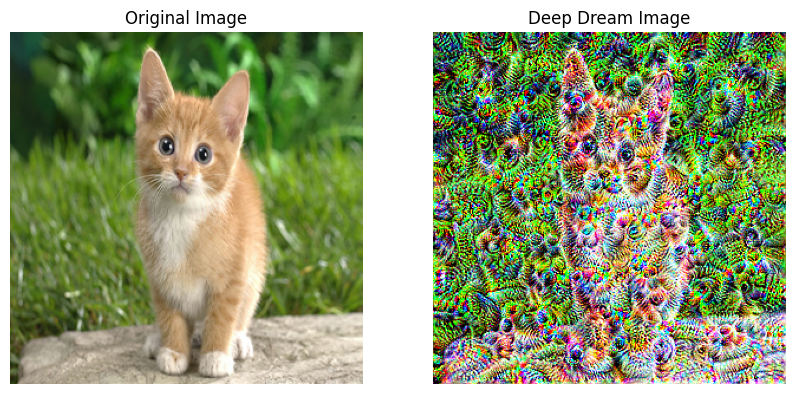

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 data
(x_train, _), (_, _) = cifar10.load_data()

# Select a random image from CIFAR-10
img = x_train[np.random.randint(len(x_train))]
img = tf.image.resize(img, (299, 299))  # Resize to match InceptionV3 input size

# Convert to float and preprocess for InceptionV3
img = tf.cast(img, tf.float32)
img = preprocess_input(img)
img = tf.expand_dims(img, axis=0)  # Add batch dimension

# Load InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False)

# Maximize the activations of these layers
names = ['mixed2', 'mixed3', 'mixed4']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
deepdream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

def calculate_loss(image, model):
    layer_activations = model(image)
    losses = [tf.math.reduce_mean(act) for act in layer_activations]
    return tf.reduce_sum(losses)

@tf.function
def deepdream_step(img, model, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = calculate_loss(img, model)
    gradients = tape.gradient(loss, img)
    gradients /= tf.math.reduce_std(gradients) + 1e-8
    img = img + gradients * learning_rate
    img = tf.clip_by_value(img, -1, 1)
    return img

def run_deep_dream_simple(model, img, steps=100, learning_rate=0.01):
    for step in range(steps):
        img = deepdream_step(img, model, learning_rate)
    return img

# Run DeepDream
img = cat_image #Comment out if you want to run CIFAR
dream_image = run_deep_dream_simple(deepdream_model, img, steps=50, learning_rate=0.1)

# Show the original and dreamed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(img.numpy() * 0.5 + 0.5))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(dream_image.numpy() * 0.5 + 0.5))
plt.title("Deep Dream Image")
plt.axis('off')

plt.show()

In [24]:
'''
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)
    '''

'\nfor i, layer in enumerate(base_model.layers):\n    print(i, layer.name)\n    '